In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
from scipy.integrate import dblquad, quad
from healpy.newvisufunc import projview, newprojplot
import tqdm
from scipy.integrate import simps
from scipy.optimize import differential_evolution, least_squares
import numba



sys.path.append('../pipeline_scripts/')
from pipeline_main import serialize_dictionary, pipeline
from pipeline_streamers import accretion_pattern
from plotting_setup import *


In [3]:
def calc_area_lat(lat_1, lat_2):
    res = 2 * np.pi * (-np.cos(lat_2) + np.cos(lat_1))
    return res


In [4]:
def equalarea_latbins(n):
    latitudes = np.arccos(1 - 2 * np.arange(n + 1) / n)
    return latitudes

In [5]:
data = pipeline(snap = 362, run = 'sink13fmr05', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:22<00:00, 186.91it/s]


In [6]:
data.calc_trans_xyz()

Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:01<00:00, 4003.23it/s]


Loop through patch present in defined shell


  0%|          | 0/961 [00:00<?, ?it/s]

100%|██████████| 961/961 [00:00<00:00, 1135.68it/s]


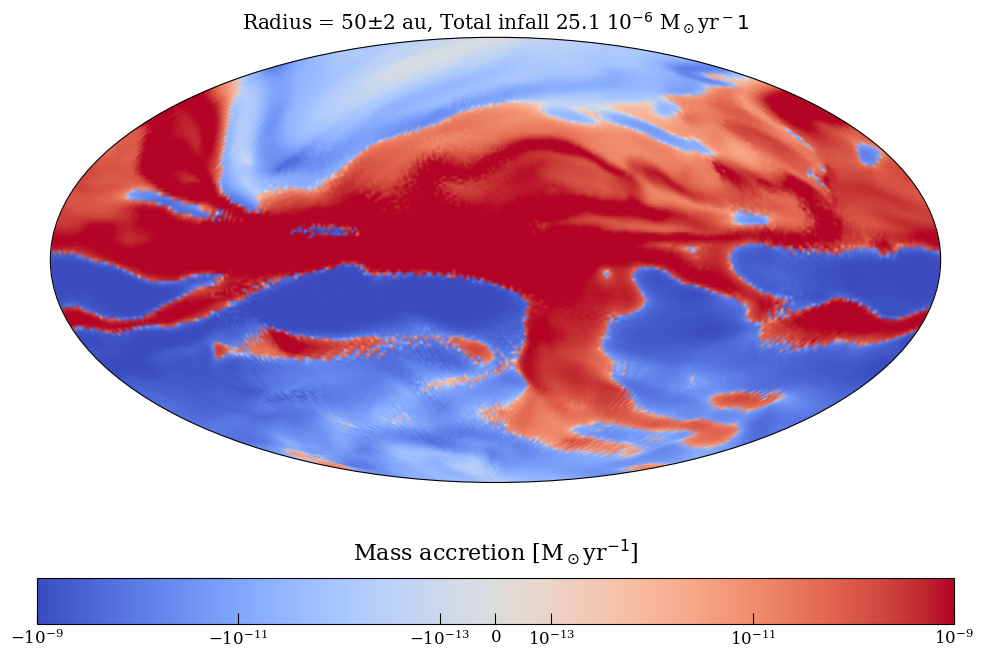

In [7]:
Lon, Lat, proj_data, total_infall_oldfunc, cell_areas = data.infall_sphere()

In [8]:
map, nside, cell_level = data.accretion_pattern(verbose=1, shell_r = 50)

  0%|          | 0/961 [00:00<?, ?it/s]

100%|██████████| 961/961 [00:06<00:00, 157.81it/s]


Number of pixels on the sphere:  21168
Pixels without any representation:  419
Percentage of no-coverage: 1.98 %


<Figure size 1200x800 with 0 Axes>

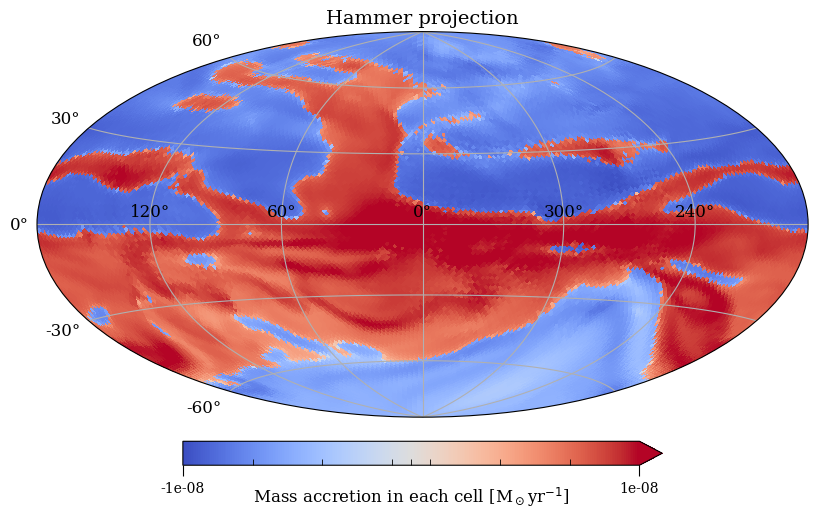

In [9]:
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    map,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    coord=["G"],
    cmap = 'coolwarm',
    flip = 'astro',
    graticule=True,
    graticule_labels=True,
    cb_orientation="horizontal",
    rot = (0, 0),
    #latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$yr$^{-1}$]'
);


In [10]:
 shell_r = 50; shell_Δpct = 0.05
 
shell_r /= data.au_length
Δ_r = np.maximum(shell_Δpct * shell_r, 2.5 * 0.5 ** data.lmax) 

patch_coord = []
patch_values = []
cell_level = []

pp = [p for p in data.sn.patches if (p.dist_xyz < shell_r * 2).any() and p.level > 5]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

for p in tqdm.tqdm(sorted_patches, disable=(not data.loading_bar)):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position) ** 2).sum() < (p.size ** 2).sum() / 12]
    if len(leafs) == 8: continue
    to_extract = (p.dist_xyz < shell_r + Δ_r) & (p.dist_xyz > shell_r - Δ_r)
    for lp in leafs:
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all(((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None])), axis=0)
        to_extract *= covered_bool

    new_xyz = p.trans_xyz[:, to_extract].T
    new_value = (p.var('d') * np.sum((p.trans_vrel *  p.trans_xyz / np.linalg.norm(p.trans_xyz, axis=0)), axis=0))[to_extract].T
    patch_values.extend(new_value.tolist())
    patch_coord.extend(new_xyz.tolist())
    cell_level.extend(p.level * np.ones(len(patch_values)))

patch_values = np.asarray(patch_values) * -data.msun_mass / data.sn.cgs.yr  
patch_coord = np.array(patch_coord)
cell_level = np.asarray(cell_level)

100%|██████████| 961/961 [00:08<00:00, 111.14it/s]


In [11]:
patch_lat = np.arccos(np.clip(patch_coord[:, 2] / np.linalg.norm(patch_coord,axis = 1), -1, 1))

In [12]:
n = 89
n_lat = equalarea_latbins(n)

[Text(0, 0.5, 'Cell count [n]'),
 Text(0.5, 0, 'Latitude [rad]'),
 Text(0.5, 1.0, 'Grey line: equal area lat bins')]

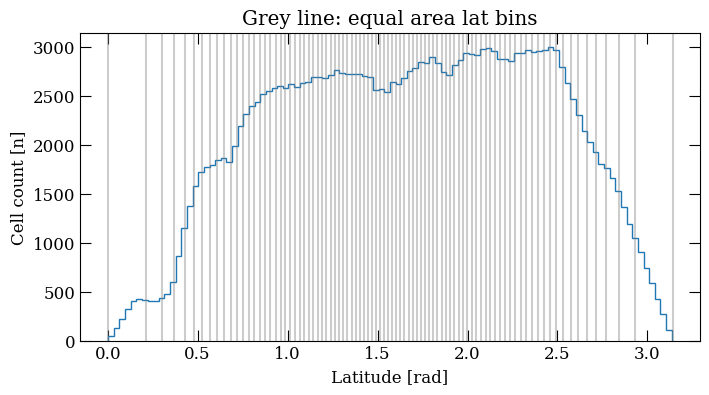

In [13]:
fig, axs = plt.subplots(figsize = (8,4))
plt.hist(patch_lat, bins = 100, histtype='step');
[plt.axvline(lat, color = 'grey', alpha = 0.4) for lat in n_lat];

axs.set(ylabel = 'Cell count [n]', xlabel = 'Latitude [rad]', title='Grey line: equal area lat bins')

In [14]:
npix = hp.nside2npix(nside)
Lat_healpy, _ = hp.pix2ang(nside, np.arange(npix)) 
nlat_bincenter = n_lat[:-1] + 0.5 * np.diff(n_lat) 

[Text(0, 0.5, 'Cell count [n]'),
 Text(0.5, 0, 'Latitude [rad]'),
 Text(0.5, 1.0, 'Grey line: equal area lat bins')]

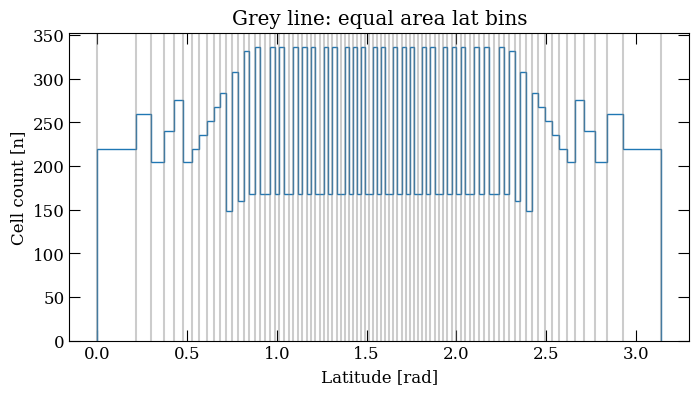

In [15]:
fig, axs = plt.subplots(figsize = (8,4))
plt.hist(Lat_healpy, bins = n_lat, histtype='step');
[plt.axvline(lat, color = 'grey', alpha = 0.4) for lat in n_lat];

axs.set(ylabel = 'Cell count [n]', xlabel = 'Latitude [rad]', title='Grey line: equal area lat bins')

In [16]:
ma_hp, _ = np.histogram(Lat_healpy, bins = n_lat, weights = map );
count,  _ = np.histogram(Lat_healpy, bins = n_lat); 

In [17]:
#mass_acc2, _ = np.histogram(patch_lat, bins = n_lat, weights=patch_values**2);
mass_acc, _ = np.histogram(patch_lat, bins = n_lat, weights= patch_values);
count,  _ = np.histogram(patch_lat, bins = n_lat); 


In [18]:
mdot_avg = mass_acc / count 
bin_area = shell_r**2 * 4 * np.pi / n


In [19]:
print('Total accretion rate for different methods:')
for string, total_acc in zip(['Only Healpy', 'Equal angle (old)', 'Healpy to latbins', 'Only latbins'],
[simps(map / cell_area, dx = cell_area), total_infall_oldfunc, simps(ma_hp / bin_area, dx = bin_area), simps(mdot_avg, dx = bin_area)]):
    print(f'{total_acc:1.4e} M_sun/yr - ' + string)



Total accretion rate for different methods:
2.5048e-05 M_sun/yr - Only Healpy
2.5126e-05 M_sun/yr - Equal angle (old)
2.4618e-05 M_sun/yr - Healpy to latbins
1.5557e-05 M_sun/yr - Only latbins


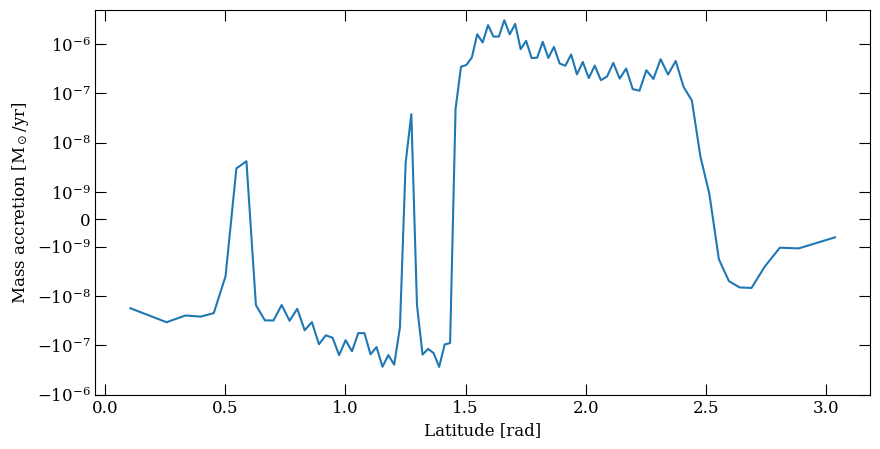

In [20]:
fig, axs = plt.subplots(figsize = (10,5))
axs.plot(nlat_bincenter, ma_hp)
axs.set(ylabel = 'Mass accretion [M$_\odot$/yr]', xlabel = 'Latitude [rad]')

axs.set_ylim(-1e-6, 5e-6)
axs.set_yscale('symlog', linthresh=1e-9, linscale=0.5);

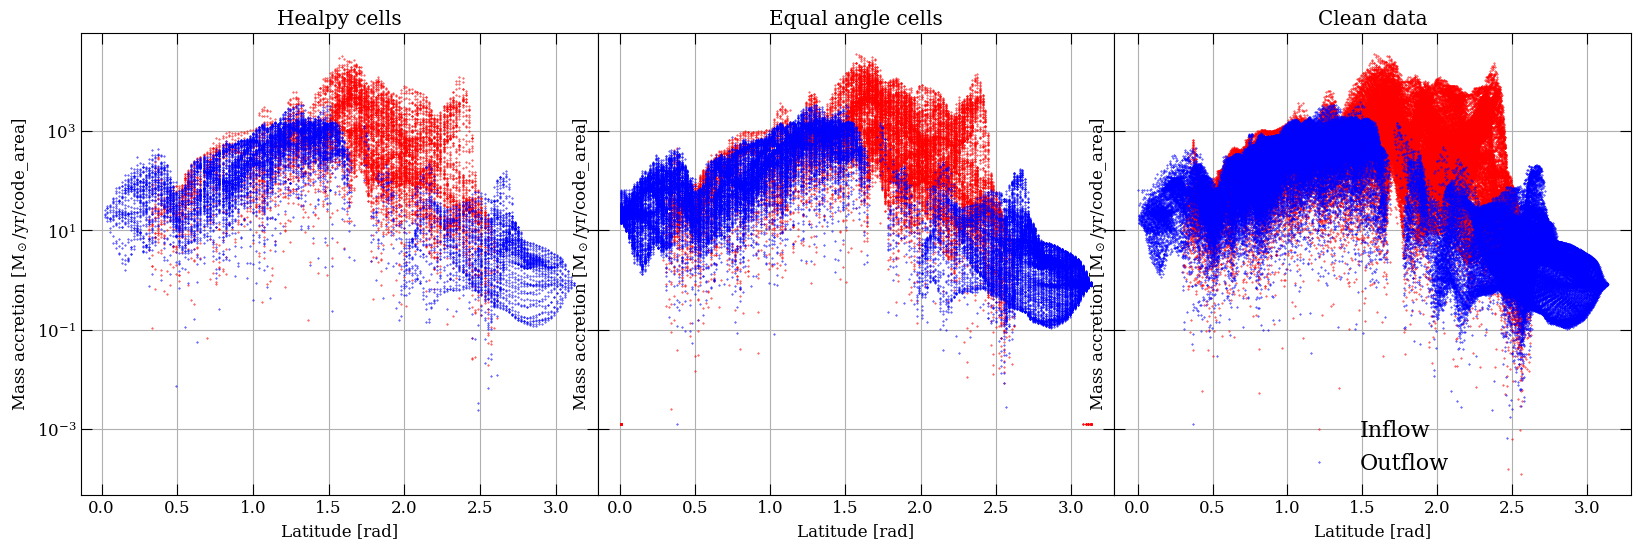

In [34]:
fig, axs = plt.subplots(1,3, figsize = (20,6), sharey = True)


for ax in axs.flatten():
    ax.set(ylabel = 'Mass accretion [M$_\odot$/yr/code_area]', xlabel = 'Latitude [rad]')
    ax.grid()
    ax.set_yscale('symlog', linthresh=1e-15, linscale=0.5);

ax = axs[0]

for ax, lat, values in zip(axs.flatten(), [Lat_healpy, Lat + np.pi/2, patch_lat], [map / cell_area, proj_data / cell_areas, patch_values]):
    bool = values > 0
    ax.semilogy(lat[bool], values[bool], '.', markersize = 0.75, color = 'red', label = 'Inflow')
    ax.semilogy(lat[~bool], abs(values)[~bool], '.', markersize = 0.75, color = 'blue', label = 'Outflow')

for ax, name in zip(axs.flatten(), ['Healpy cells', 'Equal angle cells', 'Clean data']):
    ax.set(title=name)

axs.flatten()[-1].legend(prop={'size':16}, frameon = False)


fig.subplots_adjust(wspace=0, hspace=0.1)

In [22]:
n = 21
n_lat = equalarea_latbins(n)
nlat_bincenter = n_lat[:-1] + 0.5 * (np.diff(n_lat))

  0%|          | 0/274 [00:00<?, ?it/s]

100%|██████████| 274/274 [00:00<00:00, 1987.56it/s]


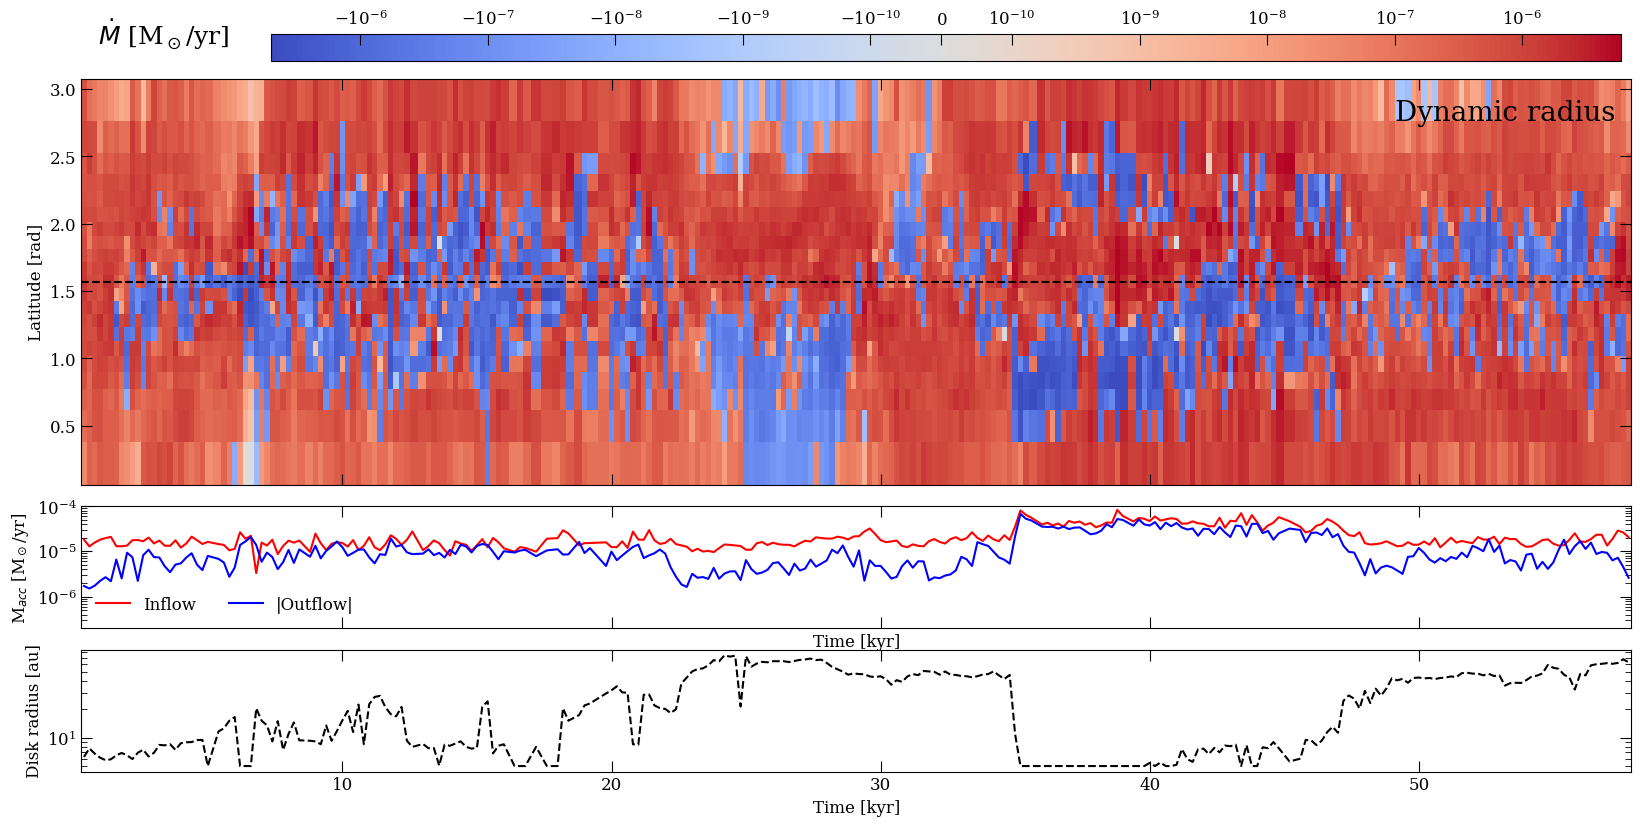

In [40]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps_defsys2.pkl', store = False)

bool = (map_data['time'] != 0) & ~np.isnan(map_data['radius'])
time = map_data['time'][bool]
radius = map_data['radius'][bool]
nside_array = map_data['nside'][bool]
maps = [map_data['maps'][i] for i in np.asarray(np.where(bool)).squeeze()]

acc = np.zeros_like(time); out = np.zeros_like(time)

mdot_lat = np.zeros((len(time), len(n_lat) - 1))
for i in tqdm.tqdm(range(len(time))):


    cell_area = hp.nside2pixarea(int(nside_array[i])) * (radius[i] / data.au_length)**2

    npix = hp.nside2npix(int(nside_array[i]))
    lat_hp, _ = hp.pix2ang(int(nside_array[i]), np.arange(npix)) 
    m = maps[i].copy()
    acc[i] = simps(m[m > 0] / cell_area, dx = cell_area)
    out[i] = simps(m[m < 0] / cell_area, dx = cell_area)

    mdot_lat[i,:], _ = np.histogram(lat_hp, bins = n_lat, weights = maps[i])

    if len(maps[i]) != npix: print('Hold up')



####_____________PLOTTING_______________________________####
fig, ax = plt.subplots(3,1, figsize = (20,9), gridspec_kw={'height_ratios': [5,1.5, 1.5]}, sharex=True)

axs = ax[2]
axs.semilogy(time * 1e-3, radius, '--', color = 'black')
axs.set(xlabel = 'Time [kyr]', ylabel = 'Disk radius [au]')

axs = ax[1]

axs.semilogy(time*1e-3, acc, color = 'red', label = 'Inflow')
axs.semilogy(time*1e-3, abs(out), color = 'blue', label = '|Outflow|')

axs.set(ylabel = 'M$_{acc}$ [M$_\odot$/yr]', xlabel = 'Time [kyr]', ylim = (2e-7, 1e-4))
axs.legend(frameon = False, ncol = 2)


axs = ax[0]

im = axs.pcolormesh(time*1e-3, nlat_bincenter, mdot_lat.T, norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=(-5e-6), vmax=6e-6), cmap = 'coolwarm')

axs.axhline(np.pi/2, color = 'black', ls = '--')

cbaxes_top = fig.add_axes([0.22, 0.9, 0.675, 0.03])
cbar_top = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax = cbaxes_top, orientation='horizontal')
cbar_top.ax.xaxis.set_ticks_position("top")
cbar_top.set_label('$\dot{M}$ [M$_\odot$/yr]', labelpad = -25, x = -0.08, rotation = 0, fontsize = 18)
cbar_top.ax.xaxis.set_ticks_position('top')
cbar_top.ax.xaxis.set_label_position('top')
axs.text(0.99, 0.95, 'Dynamic radius', transform=axs.transAxes, ha='right', va='top', fontsize = 20)


axs.set( ylabel = 'Latitude [rad]')
fig.subplots_adjust(wspace=0, hspace=0.1)

100%|██████████| 274/274 [00:00<00:00, 1237.09it/s]


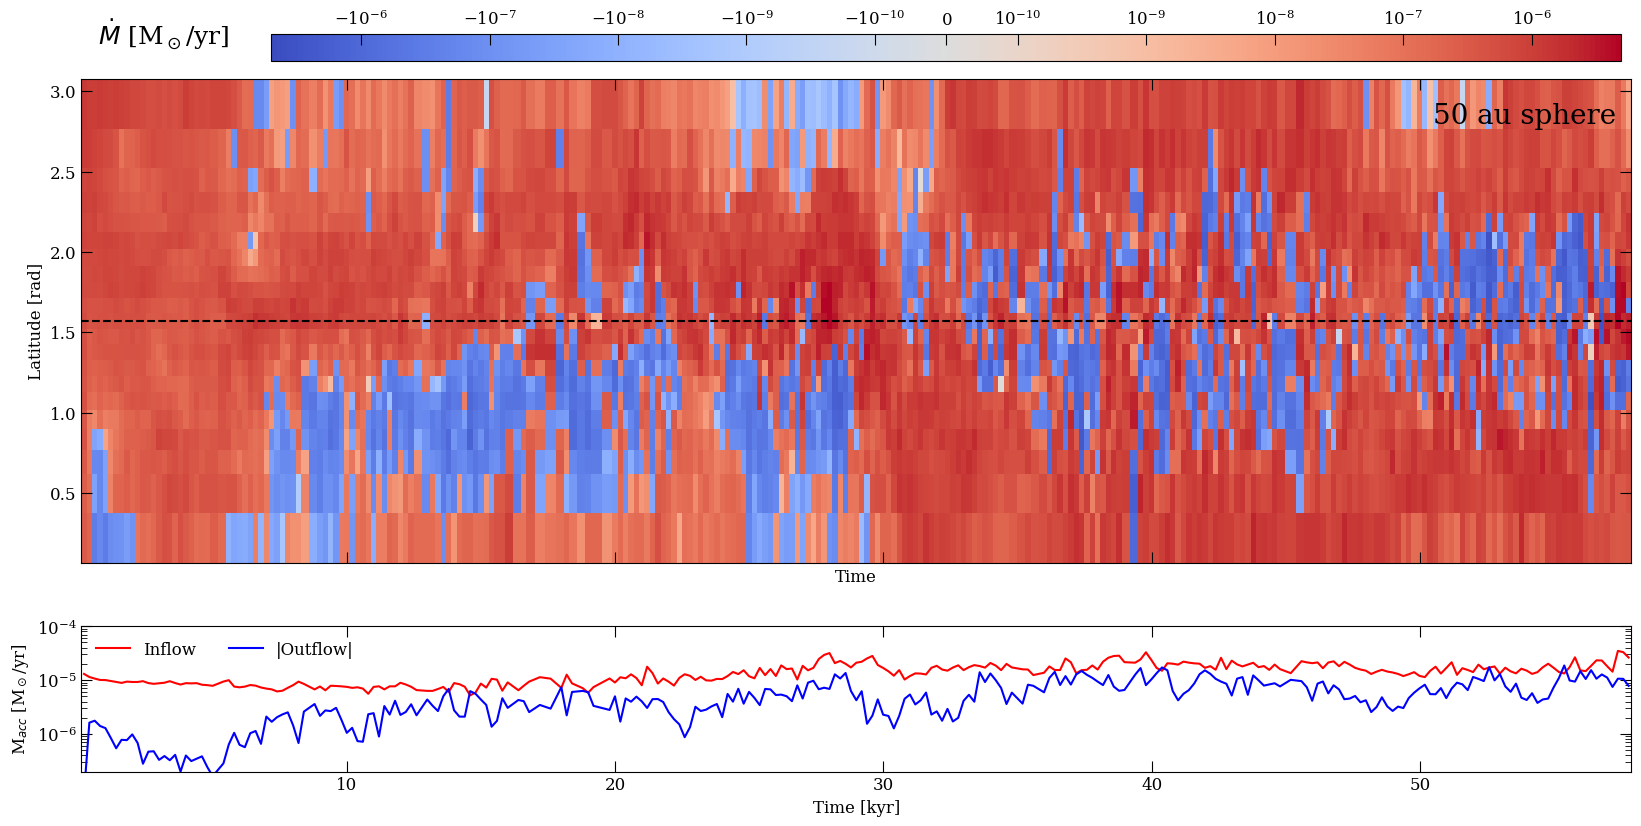

In [41]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps.pkl', store = False)

nside = 45
npix = hp.nside2npix(nside)
lat_hp, _ = hp.pix2ang(nside, np.arange(npix)) 
shell_r = 50 / data.au_length
cell_area = npix * shell_r**2

bool = (map_data['time'] != 0)
time = map_data['time'][bool]
maps = [map_data['maps'][i] for i in np.asarray(np.where(bool)).squeeze()]

acc = np.zeros_like(time); out = np.zeros_like(time)

mdot_lat = np.zeros((len(time), len(n_lat) - 1))
for i in tqdm.tqdm(range(len(time))):
    mdot_lat[i,:], _ = np.histogram(lat_hp, bins = n_lat, weights = maps[i])
    m = maps[i].copy()
    acc[i] = simps(m[m > 0] / cell_area, dx = cell_area)
    out[i] = simps(m[m < 0] / cell_area, dx = cell_area)

    if len(maps[i]) != npix: print('Hold up')

####_____________PLOTTING_______________________________####

fig, ax = plt.subplots(2,1, figsize = (20,9), gridspec_kw={'height_ratios': [5,1.5]}, sharex=True)

axs = ax[1]

axs.semilogy(time*1e-3, acc, color = 'red', label = 'Inflow')
axs.semilogy(time*1e-3, abs(out), color = 'blue', label = '|Outflow|')

axs.set(ylabel = 'M$_{acc}$ [M$_\odot$/yr]', xlabel = 'Time [kyr]', ylim = (2e-7, 1e-4))
axs.legend(frameon = False, ncol = 2)


axs = ax[0]

im = axs.pcolormesh(time*1e-3, nlat_bincenter, mdot_lat.T, norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=(-5e-6), vmax=5e-6), cmap = 'coolwarm')

cbaxes_top = fig.add_axes([0.22, 0.9, 0.675, 0.03])
cbar_top = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax = cbaxes_top, orientation='horizontal')
cbar_top.ax.xaxis.set_ticks_position("top")
cbar_top.set_label('$\dot{M}$ [M$_\odot$/yr]', labelpad = -25, x = -0.08, rotation = 0, fontsize = 18)
cbar_top.ax.xaxis.set_ticks_position('top')
cbar_top.ax.xaxis.set_label_position('top')
axs.text(0.99, 0.95, '50 au sphere', transform=axs.transAxes, ha='right', va='top', fontsize = 20)


axs.set(xlabel = 'Time', ylabel = 'Latitude [rad]')

axs.axhline(np.pi/2, color = 'black', ls = '--')




100%|██████████| 275/275 [00:00<00:00, 5466.51it/s]


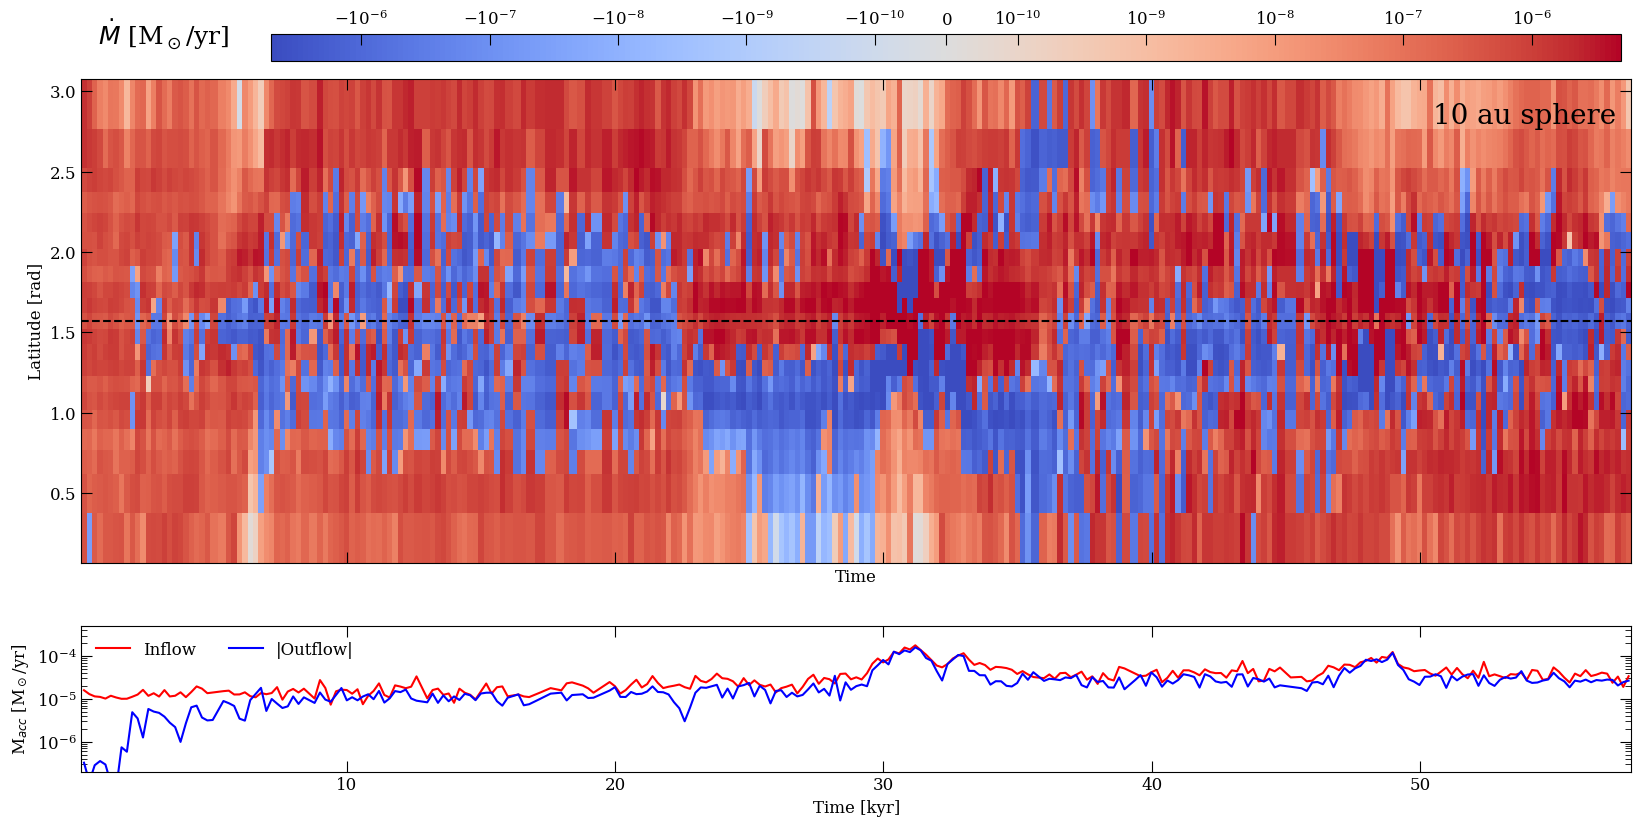

In [46]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps_10au.pkl', store = False)

nside = 45
npix = hp.nside2npix(nside)
lat_hp, _ = hp.pix2ang(nside, np.arange(npix)) 
shell_r = 10 / data.au_length

bool = (map_data['time'] != 0) | (map_data['nside'] != 0)
time = map_data['time'][bool]
nside_array = map_data['nside'][bool]
maps = [map_data['maps'][i] for i in np.asarray(np.where(bool)).squeeze()]

acc = np.zeros_like(time); out = np.zeros_like(time)

mdot_lat = np.zeros((len(time), len(n_lat) - 1))
for i in tqdm.tqdm(range(len(time))):

    cell_area = hp.nside2pixarea(int(nside_array[i])) * shell_r**2

    npix = hp.nside2npix(int(nside_array[i]))
    lat_hp, _ = hp.pix2ang(int(nside_array[i]), np.arange(npix)) 
    m = maps[i].copy()
    acc[i] = simps(m[m > 0] / cell_area, dx = cell_area)
    out[i] = simps(m[m < 0] / cell_area, dx = cell_area)

    mdot_lat[i,:], _ = np.histogram(lat_hp, bins = n_lat, weights = maps[i])

    if len(maps[i]) != npix: print('Hold up')

####_____________PLOTTING_______________________________####

fig, ax = plt.subplots(2,1, figsize = (20,9), gridspec_kw={'height_ratios': [5,1.5]}, sharex=True)

axs = ax[1]

axs.semilogy(time*1e-3, acc, color = 'red', label = 'Inflow')
axs.semilogy(time*1e-3, abs(out), color = 'blue', label = '|Outflow|')

axs.set(ylabel = 'M$_{acc}$ [M$_\odot$/yr]', xlabel = 'Time [kyr]', ylim = (2e-7, 5e-4))
axs.legend(frameon = False, ncol = 2)


axs = ax[0]

im = axs.pcolormesh(time*1e-3, nlat_bincenter, mdot_lat.T, norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=(-5e-6), vmax=5e-6), cmap = 'coolwarm')

cbaxes_top = fig.add_axes([0.22, 0.9, 0.675, 0.03])
cbar_top = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax = cbaxes_top, orientation='horizontal')
cbar_top.ax.xaxis.set_ticks_position("top")
cbar_top.set_label('$\dot{M}$ [M$_\odot$/yr]', labelpad = -25, x = -0.08, rotation = 0, fontsize = 18)
cbar_top.ax.xaxis.set_ticks_position('top')
cbar_top.ax.xaxis.set_label_position('top')
axs.text(0.99, 0.95, '10 au sphere', transform=axs.transAxes, ha='right', va='top', fontsize = 20)


axs.set(xlabel = 'Time', ylabel = 'Latitude [rad]')

axs.axhline(np.pi/2, color = 'black', ls = '--')




100%|██████████| 265/265 [00:00<00:00, 2363.97it/s]


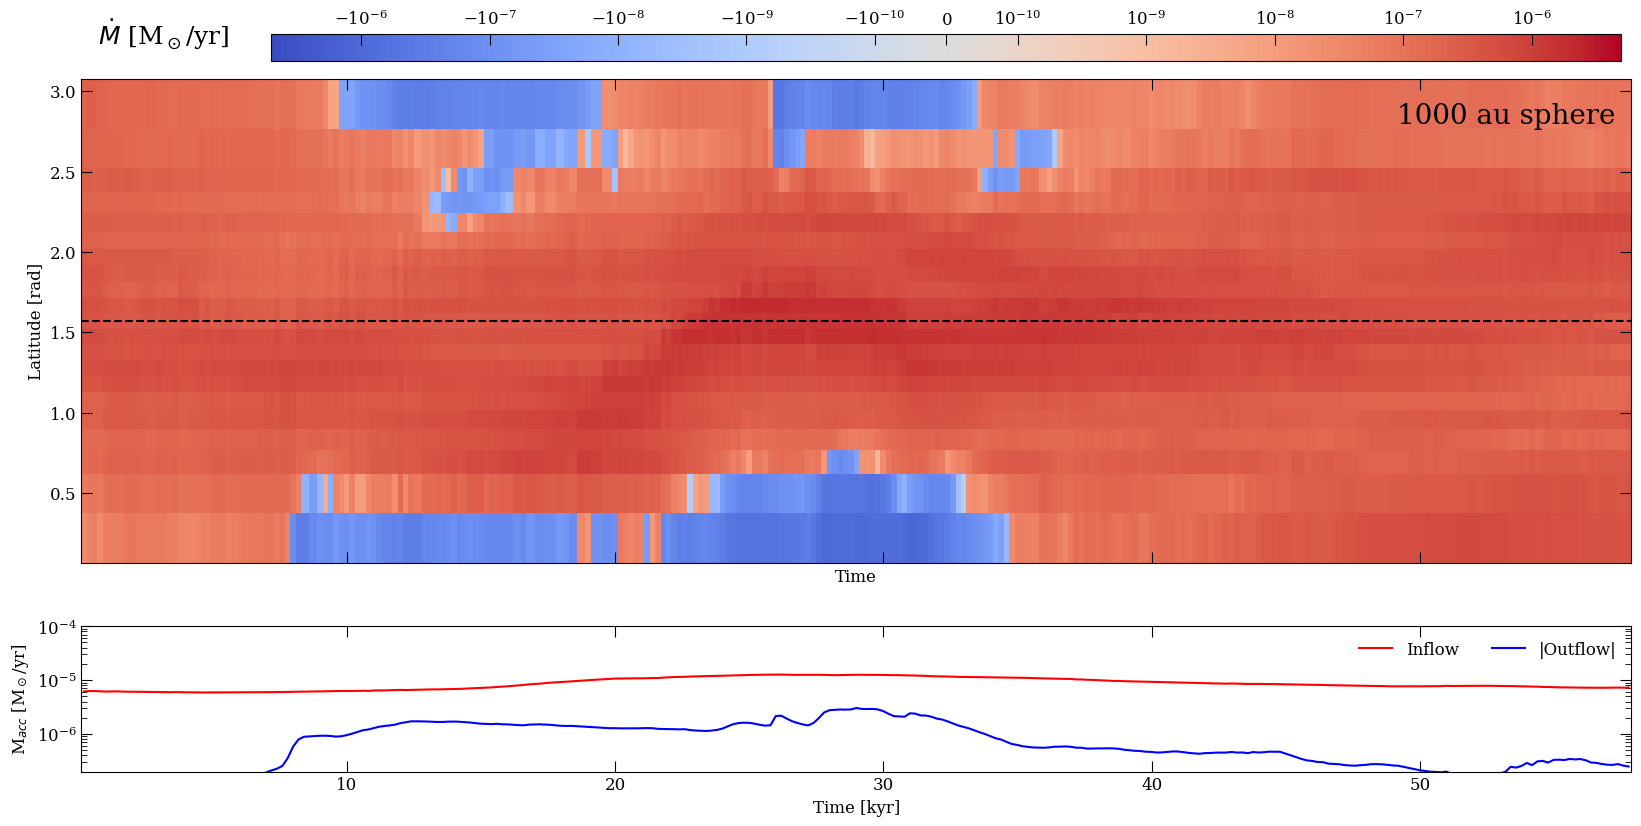

In [44]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps_1e3au.pkl', store = False)

shell_r = 1000 / data.au_length

bool = (map_data['time'] != 0) | (map_data['nside'] != 0)
time = map_data['time'][bool]
nside_array = map_data['nside'][bool]
maps = [map_data['maps'][i] for i in np.asarray(np.where(bool)).squeeze()]

acc = np.zeros_like(time); out = np.zeros_like(time)

mdot_lat = np.zeros((len(time), len(n_lat) - 1))
for i in tqdm.tqdm(range(len(time))):

    npix = hp.nside2npix(int(nside_array[i]))

    cell_area = hp.nside2pixarea(int(nside_array[i])) * shell_r**2    
    lat_hp, _ = hp.pix2ang(int(nside_array[i]), np.arange(npix)) 
    m = maps[i].copy()
    acc[i] = simps(m[m > 0] / cell_area, dx = cell_area)
    out[i] = simps(m[m < 0] / cell_area, dx = cell_area)

    mdot_lat[i,:], _ = np.histogram(lat_hp, bins = n_lat, weights = maps[i])

    if len(maps[i]) != npix: print('Hold up')

####_____________PLOTTING_______________________________####

fig, ax = plt.subplots(2,1, figsize = (20,9), gridspec_kw={'height_ratios': [5,1.5]}, sharex=True)

axs = ax[1]

axs.semilogy(time*1e-3, acc, color = 'red', label = 'Inflow')
axs.semilogy(time*1e-3, abs(out), color = 'blue', label = '|Outflow|')

axs.set(ylabel = 'M$_{acc}$ [M$_\odot$/yr]', xlabel = 'Time [kyr]', ylim = (2e-7, 1e-4))
axs.legend(frameon = False, ncol = 2)


axs = ax[0]

im = axs.pcolormesh(time*1e-3, nlat_bincenter, mdot_lat.T, norm=colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin=(-5e-6), vmax=5e-6), cmap = 'coolwarm')

cbaxes_top = fig.add_axes([0.22, 0.9, 0.675, 0.03])
cbar_top = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax = cbaxes_top, orientation='horizontal')
cbar_top.ax.xaxis.set_ticks_position("top")
cbar_top.set_label('$\dot{M}$ [M$_\odot$/yr]', labelpad = -25, x = -0.08, rotation = 0, fontsize = 18)
cbar_top.ax.xaxis.set_ticks_position('top')
cbar_top.ax.xaxis.set_label_position('top')
axs.text(0.99, 0.95, '1000 au sphere', transform=axs.transAxes, ha='right', va='top', fontsize = 20)


axs.set(xlabel = 'Time', ylabel = 'Latitude [rad]')

axs.axhline(np.pi/2, color = 'black', ls = '--')


